# Spatial mapping of 50 cell types across the mouse brain - cell2location

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'

# this line forces theano to use th GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
#os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'
#os.environ["OMP_NUM_THREADS"] = '8'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location

from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda0` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.    
You should see a message similar to the one below confirming that `theano` started using the GPU:
```
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:89:00.0)
```

## Outline

I. Spatially mapping cell types

1. Loading Visium data and single cell reference, QC
2. Exploring the data: UMAP of cells and locations
3. cell2location analysis in one step

II. Results and downstream analysis:

1. Loading cell2location results
2. Visialising cell locations
3. Automatic discrete region identification by clustering cell densities
4. Analyse cell type density gradients using diffusion maps
5. Identify co-occuring cell type combinations using matrix factorisation

## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location/notebooks/data/processed_data/'
results_folder = '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/notebooks/results/mouse_viseum_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [3]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [4]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'], 
    index_unique=None
)
obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Now let's look at QC: total number of counts and total number of genes per spot

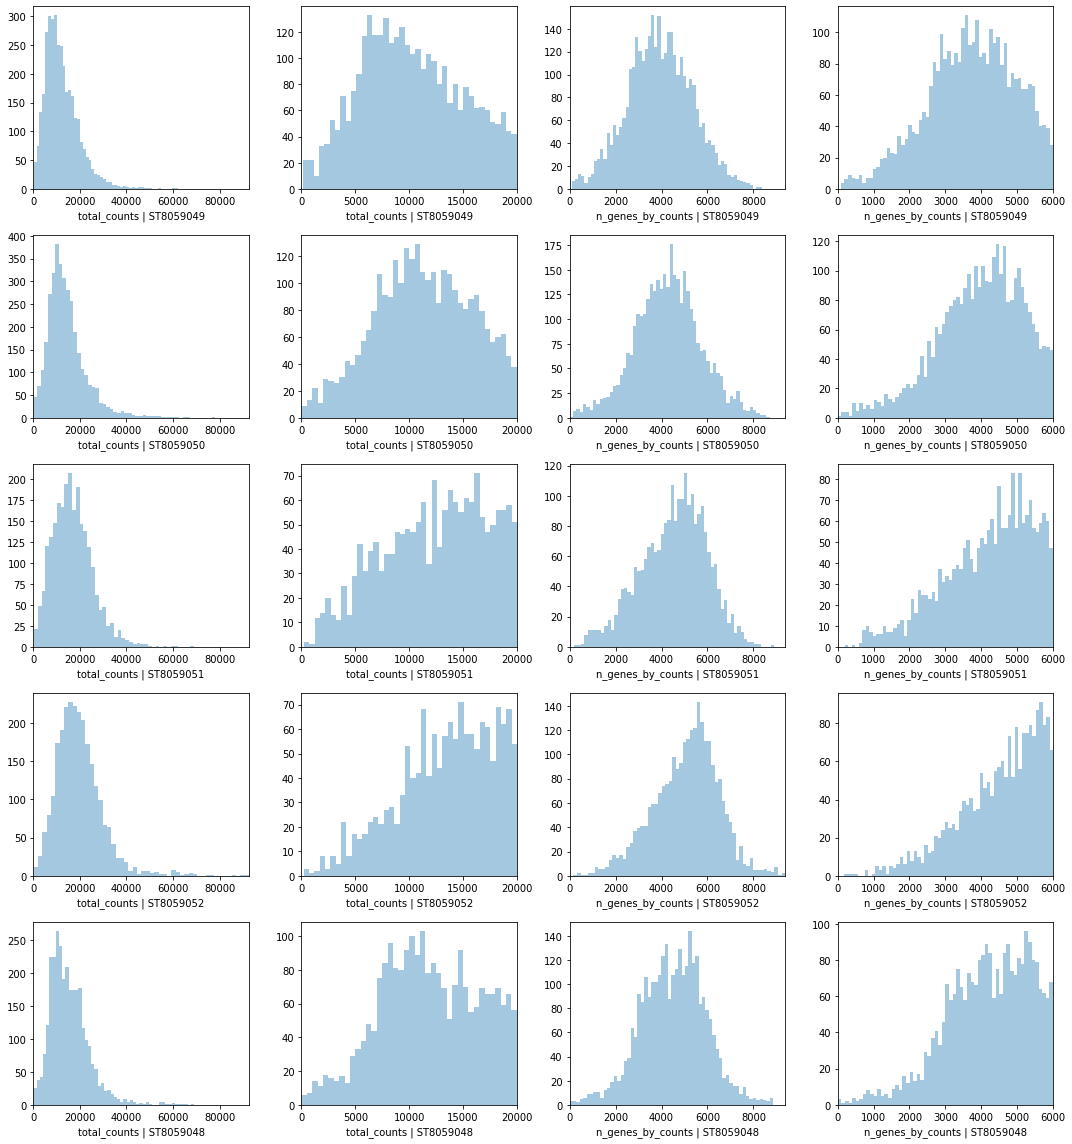

In [5]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


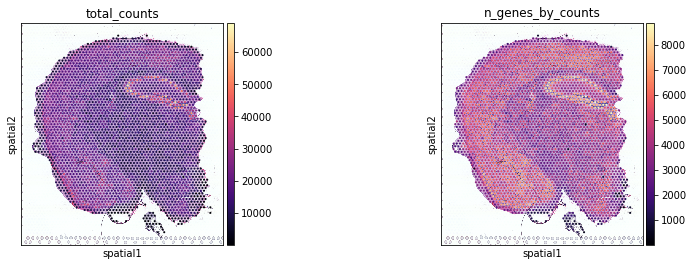

In [6]:
sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
              color=['total_counts', 'n_genes_by_counts'], size=1,
              gene_symbols='SYMBOL')

Here we show how to use scanpy to plot results over histology section using anndata object from one section, and 

Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name2' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'image_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'slide' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'position' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'SYMBOL' as categorical


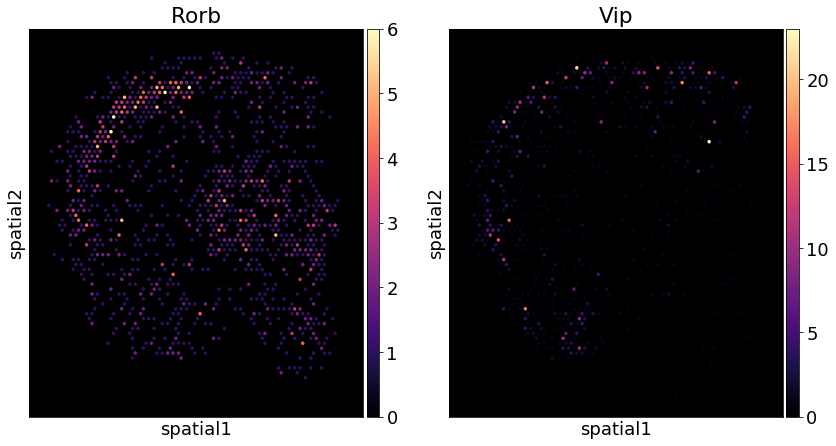

In [7]:
rcParams["axes.facecolor"] = "black"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(adata[adata.obs["sample"]==adata.obs["sample"].unique()[0], :], 
              color=["Rorb", "Vip"], img_key=None, #size=1,
              vmin=0, cmap='magma', #vmax=3.8,
              gene_symbols='SYMBOL'
             )

In [8]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "snRNA_s144600_raw_20200128.h5ad")

## Cell type annotations
labels = pd.read_csv(results_folder + 'snRNA_annotation_20200229.csv', index_col=0)

adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['sample'].isin(['nan']),]

labels

Add cell type labels as columns in `adata.obs`

In [11]:
adata_snrna_raw = adata_snrna_raw[labels.index,]
adata_snrna_raw.obs = pd.concat([labels, adata_snrna_raw.obs], axis=1)

Add counts matrix as `adata.raw` 

In [12]:
adata_vis = adata.copy()
adata_snrna_raw.raw = adata_snrna_raw
adata_vis.raw = adata_vis

Select two spatial samples to speed up the analysis, one from each biological replicate.

In [13]:
s = ['ST8059048', 'ST8059051']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(s),:]

slides = {i: slides[i] for i in s}

## 2. Show UMAP of cells and locations

In [14]:
sc.pp.log1p(adata_snrna_raw)
sc.tl.pca(adata_snrna_raw, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata_snrna_raw, n_neighbors = 100, n_pcs = 50)
sc.tl.umap(adata_snrna_raw, min_dist = 0.2, spread = 4)

... storing 'annotation_1' as categorical


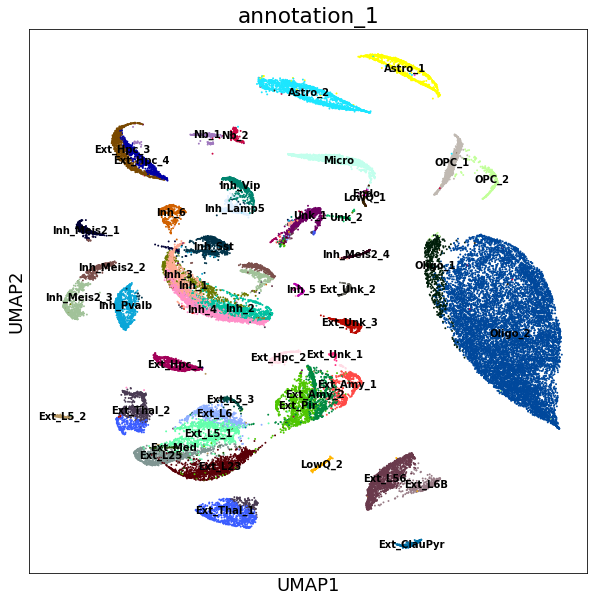

In [15]:
rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
           color_map = 'RdPu', ncols = 1, legend_loc='on data',
           legend_fontsize=10)

Now we look at the UMAP of Visium spots

... storing 'sample' as categorical
... storing 'sample_name' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


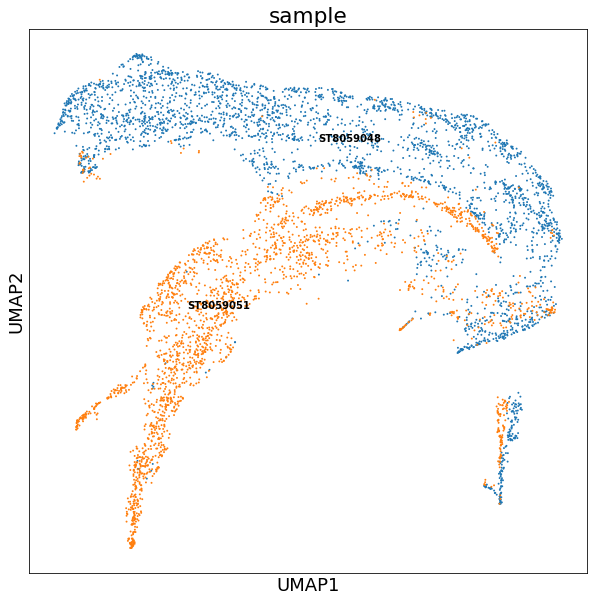

In [16]:
sc.tl.pca(adata_vis, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata_vis, n_neighbors = 100, n_pcs = 50)
sc.tl.umap(adata_vis, min_dist = 0.2, spread = 4)

rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_vis, color=['sample'], size=20,
           color_map = 'RdPu', ncols = 1, legend_loc='on data',
           legend_fontsize=10)

## 3. cell2location analysis in one step

Here we show how to perform the first step in one function run - train cell2location model to learn cell locations.

In [ ]:
sc.settings.set_figure_params(dpi = 100, color_map = 'RdPu', dpi_save = 100,
                              vector_friendly = True, format = 'pdf',
                              facecolor='white')

r = cell2location.run_cell2location(
    
      # Single cell reference data as anndata object (could also be pd.DataFrame with signatures)
      sc_data=adata_snrna_raw, 
      # Spatial data as anndata object
      sp_data=adata_vis,

      # the column in sc_data.obs that gives cluster idenitity of each cell
      summ_sc_data_args={'cluster_col': "annotation_1"},

      train_args={'use_raw': True, # By default uses raw slots in both of the input datasets.
                  'n_iter': 20000, # Increase the number of iterations if needed (see below)
                  'sample_name_col': 'sample'}, # Column in sp_data.obs with Sample ID

      # Number of posterios samples to use for estimating parameters,
      # reduce if not enough GPU memory
      posterior_args={'n_samples': 1000}, 

    
      export_args={'path': results_folder + 'std_model/', # path where to save results
                   'run_name_suffix': '' # optinal suffix to name the run
                  },

      model_kwargs={ # Prior on the number of cells, cell types and co-located combinations
          
                    'cell_number_prior': {
                        # Use visual inspection of the tissue image to determine 
                        # the average number of cells per spot,
                        # an approximate count is good enough:
                        'cells_per_spot': 8, 
                        # Prior on the number of cell types (or factors) in each spot
                        'factors_per_spot': 7, 
                        # Prior on the number of correlated cell type combinations in each spot
                        'combs_per_spot': 2.5
                    },
          
                     # Prior on change in sensitivity between technologies
                    'gene_level_prior':{
                        # Prior on average change in expression level from scRNA-seq to spatial technology,
                        # this reflects your belief about the sensitivity of the technology in you experiment
                        'mean': 1/2, 
                        # Prior on how much individual genes differ from that average,
                        # a good choice of this value should be lower that the mean
                        'sd': 1/4
                    }
      }
)

The results are saved to:  

In [18]:
results_folder + 'std_model/' + r['run_name']

'/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/notebooks/results/mouse_viseum_snrna/std_model/CoLocationModelNB4V2_50clusters_5396locations_11945genes'

Trained model object can be pulled from `r['mod']`, cell locations are added to `r['sp_data']` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are always saved to the results directory. 

When `'save_model': True`, the trained model `r['mod']` is also saved as a pickle file. You can load the model later and continue training. 

In [21]:
r = {'run_name': 'CoLocationModelNB4V2_50clusters_5396locations_11945genes'}

#### Evaluating training

Now we need to check if our model has trained successfully by looking at the loss / cost function over training iterations. This plot omits the first 20% of training iterations during which loss changes by orders of magnitude. If there are large changes during the last few thousands of iterations we recommend increasing the `'n_iter'` parameter.

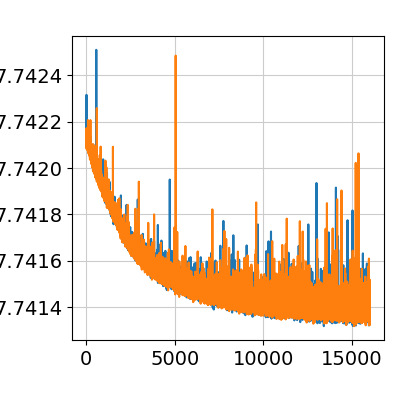

In [22]:
from IPython.display import Image
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/training_history_without_first_20perc.png',
      width=400)

We also need to evaluate the reconstruction accuracy or how well cell types and uniform background explain spatial data bu comparing expected value of the model (Poisson mean) to observed count of each gene across locations. The ideal case is perfect diagonal plot.

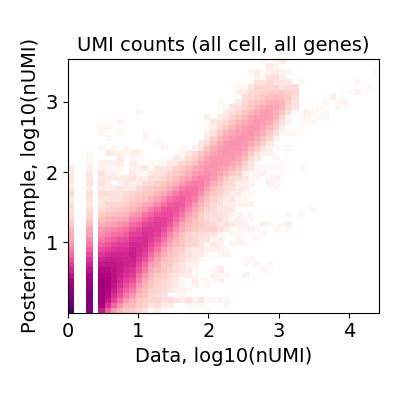

In [23]:
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/data_vs_posterior_mean_Poisson_rate.png',
      width=400)

Finally, we need to evaluate robustness of the identified locations by comparing consistency of inferred locations between two independent training restarts.

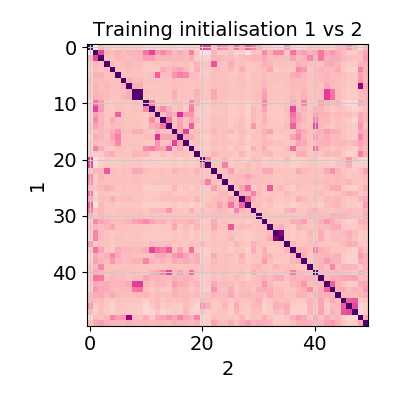

In [24]:
Image(filename=results_folder + 'std_model/'+r['run_name']+'/plots/evaluate_stability.png',
      width=400)

Modules and their versions used for this analysis

In [45]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.1.3
ipykernel._version 5.1.3
json 2.0.9
re 2.2.1
IPython 7.11.1
IPython.core.release 7.11.1
logging 0.5.1.2
zlib 1.0
traitlets 4.3.3
six 1.13.0
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
traitlets._version 4.3.3
decorator 4.4.1
argparse 1.1
pygments 2.5.2
pexpect 4.7.0
ptyprocess 0.6.0
pickleshare 0.7.5
backcall 0.1.0
prompt_toolkit 2.0.10
jedi 0.15.2
parso 0.5.2
urllib.request 3.7
jupyter_client 5.3.4
jupyter_client._version 5.3.4
zmq 18.1.1
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 18.1.1
zmq.sugar.constants 40302
zmq.sugar.version 18.1.1
jupyter_core 4.6.1
jupyter_core.version 4.6.1
_curses b'2.2'
dateutil 2.8.1
decimal 1.70
_decimal 1.70
distutils 3.7.6
ipywidgets 7.5.1
ipywidgets._version 7.5.1
scanpy 1.5.1
numpy 1.17.3
numpy.core 1.17.3
numpy.core._multiarray_umath 3.1
numpy.lib 1.17.3
numpy.linalg._umath_linalg b'0.1.5'
anndata 0.7.3
h5py 2.10.0
natsort 7.0.0
pandas 1.0.3
pytz 2019.3
cs